# Modified equation to to keep real tax rates 

## Import the model class
This class incorporates most of the methods used to manage a model. 

In [1]:
%matplotlib inline

In [2]:
 %load_ext autoreload
 %autoreload 2

In [3]:
from modelclass import model 
model.widescreen()
model.scroll_off()
import modelmf

## Load a pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. 

In [4]:
mpak,baseline = model.modelload(r'C:\wb new\Modelflow\jupyter\pak.pcim',run=1,silent=1,keep='No tax change')
mpakdisplay,_ = model.modelload(r'C:\wb new\Modelflow\jupyter\pak.pcim',run=1,silent=1,keep='No tax change')

## Create a experiment  where nominal tax is set to 29

In [5]:
alternative_nominal = baseline.upd('<2023 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 29')
_ = mpak(alternative_nominal,2021,2100,keep=f'Nominal model nominal tax = 29',alfa=0.5)

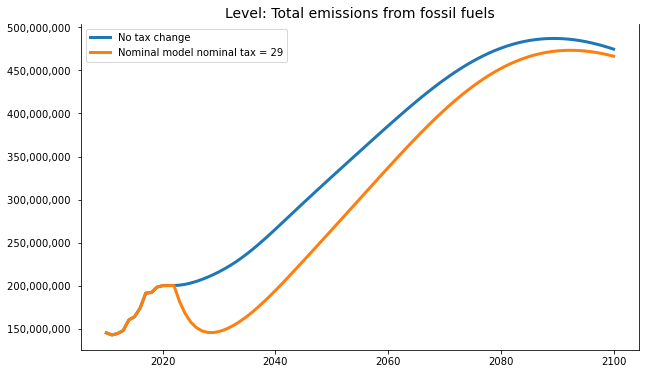

In [6]:
mpak.keep_plot('PAKCCEMISCO2TKN',2010,2100,legend=1);

## Run same expriement but with real price set at 29

First we use update to set the value to 29 in 2024

Then use a new functionality mfcalc to do a recusrive calculation taht is not easy to do straight up python



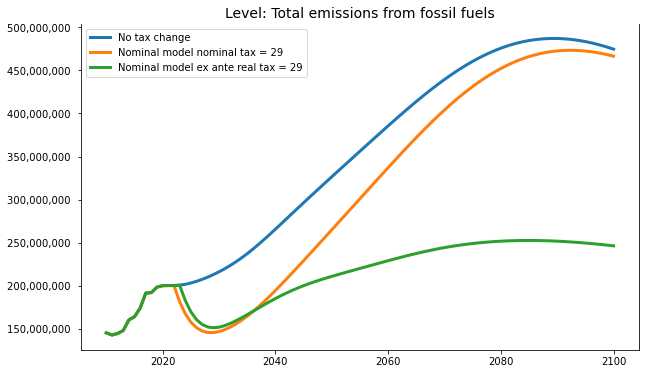

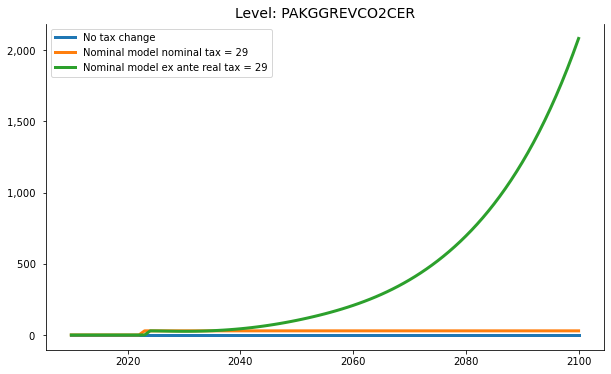

In [7]:
import modelmf

alternative_real_exante = baseline.upd('<2024 > PAKGGREVCO2GER PAKGGREVCO2OER PAKGGREVCO2CER = 29')   # Set the rate equal to 29 nominal in 2024

alternative_real_exante=alternative_real_exante.mfcalc("PAKGGREVCO2GER =PAKGGREVCO2GER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1)",2025, 2100)  #runs the calculation over the period speciied
alternative_real_exante=alternative_real_exante.mfcalc("PAKGGREVCO2OER =PAKGGREVCO2OER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1)",2025, 2100)
alternative_real_exante=alternative_real_exante.mfcalc("PAKGGREVCO2CER =PAKGGREVCO2CER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1)",2025, 2100)

_ = mpak(alternative_real_exante,2021,2100,keep=f'Nominal model ex ante real tax = 29',alfa=0.5)

mpak.keep_plot('PAKCCEMISCO2TKN PAKGGREVCO2CER',2010,2100,legend=1);



## Now try and use ex post inflation instead of ex ante to deflate



In the mpak model the carbon tax variables ```PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER``` where exogenous variables. Now equations for these variables are introduced to make them endogenous and a new modified model is created. 

Each tax variable are now determined by an equation which makes its growth rate follow the growth rate of inflation  ```PAKNECONPRVTXN```. 

The new equations are made fixable, so the previous behavior can be preserved. The behavior in each year is determined by the ```<name>_D``` variable. If it is 1 the variable will take the value ```<name>_X``` if the value is 0 the expression will 
determine the value


### First we create a new model  object with the revised equations

In [8]:


mpakreal,_ = mpak.equpdate('''\
<fixable> PAKGGREVCO2CER = PAKGGREVCO2CER(-1) * PAKNECONPRVTXN / PAKNECONPRVTXN(-1)
<fixable> PAKGGREVCO2OER = PAKGGREVCO2OER(-1) * PAKNECONPRVTXN / PAKNECONPRVTXN(-1)
<fixable> PAKGGREVCO2GER = PAKGGREVCO2GER(-1) * PAKNECONPRVTXN / PAKNECONPRVTXN(-1)
''',add_add_factor=False, calc_add=False,newname='Pak model, real adjusted tax (endog)')






The model:"Pak model" got new equations, new model name is:"Pak model, real adjusted tax (endog)"
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2CER = (PAKGGREVCO2CER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1))* (1-PAKGGREVCO2CER_D)+ PAKGGREVCO2CER_X*PAKGGREVCO2CER_D$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2OER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2OER = (PAKGGREVCO2OER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1))* (1-PAKGGREVCO2OER_D)+ PAKGGREVCO2OER_X*PAKGGREVCO2OER_D$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2GER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2GER = (PAKGGREVCO2GER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1))* (1-PAKGGREVCO2GER_D)+ PAKGGREVCO2GER_X*PAKGGREVCO2GER_D$
Adjust calc:No frml for adjustment calc  



### Now we need to create the _X variables for the new equation (it has both _X and _D variables)

First set the _X variables equal to the original bvalues of the tax rate


Then set the _D =1 which means the variable is exogenized (i.e. we use the _x value not the result of the equation do this for all time

In [9]:
baseline_real=baseline.copy()

baseline_real = baseline_real.mfcalc('''
PAKGGREVCO2CER_X = PAKGGREVCO2CER
PAKGGREVCO2GER_X = PAKGGREVCO2GER
PAKGGREVCO2OER_X = PAKGGREVCO2OER
''')

baseline_real = baseline_real.upd('''
<-0 -1> 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_D = 1
''')
res = mpakreal(baseline_real,2021,2100,alfa=0.5,keep='Baseline - adjusted model')

## Nominal tax of 29 in the real model. 

In [10]:
scenario_real_CTax = baseline_real.upd('''
<2024 > 
PAKGGREVCO2CER_x PAKGGREVCO2GER_x PAKGGREVCO2OER_x = 29 # Sets the exogenous value to 29 in 2024
<2025 2100 > 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_d = 0   # Endogenizes the new equation for the rest of time so that the real stays at 29
''')


_ = mpakreal(scenario_real_CTax,2021,2100,alfa=0.5,keep='Real model real tax = 29 in 2022 currency units')



## Real tax in the real model 


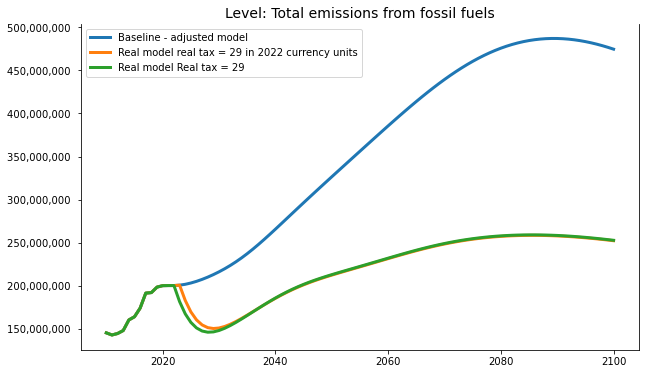

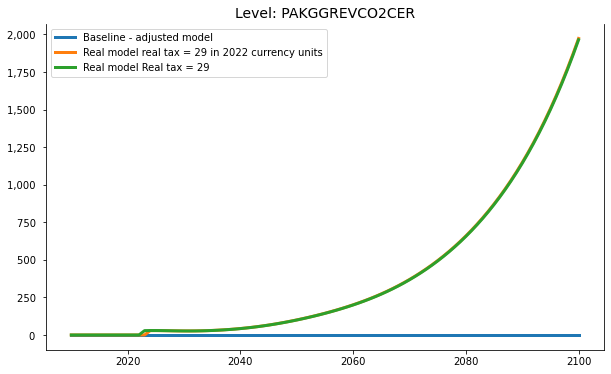

In [11]:
alternative_real_model_real_tax = baseline_real.upd('''
<2023 2023> 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_D = 1
PAKGGREVCO2CER_X PAKGGREVCO2GER_X PAKGGREVCO2OER_X = 29
<2024 2100> 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_D = 0 
''')
res = mpakreal(alternative_real_model_real_tax,2021,2100,alfa=0.5,keep='Real model Real tax = 29',silent=1)
mpakreal.keep_plot('PAKCCEMISCO2TKN PAKGGREVCO2CER',2010,2100,legend=1);

# Now look at the results for nominal and real tax. 

In [12]:
mpakdisplay.keep_solutions = {**mpak.keep_solutions,**mpakreal.keep_solutions}

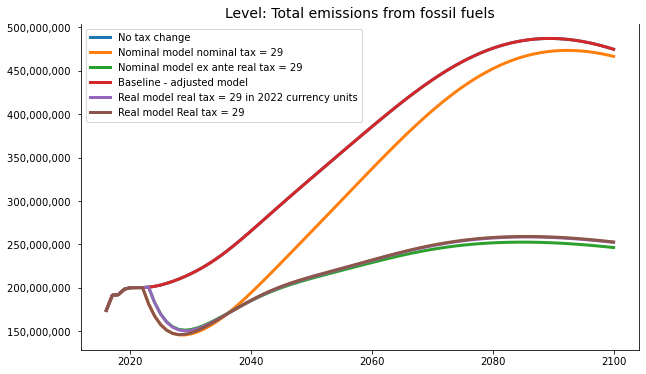

In [13]:
mpakreal
mpakdisplay.keep_plot('PAKCCEMISCO2TKN',2016,2100,diff=0,legend=1);

## Check nominal tax gives the same result in the two models 

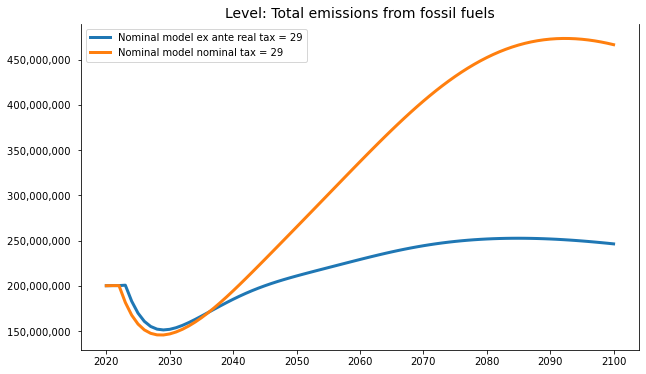

In [15]:
with mpakdisplay.keepswitch(scenarios='*nominal*'):
    mpakdisplay.keep_plot('PAKCCEMISCO2TKN',2020,2100,diff=0,legend=1);